- check difference between train data and test data by adversarial validation, surprisingly, training data and test data are completely different.

In [1]:
import pandas as pd
import numpy as np
import warnings
import datetime
from time import time
from tqdm import tqdm_notebook as tqdm
from collections import Counter
from sklearn import preprocessing
from sklearn.model_selection import GroupKFold, StratifiedKFold
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix, cohen_kappa_score
import lightgbm as lgb
from functools import partial
import json
import copy
import time
import seaborn as sns
import scipy as sp
pd.set_option('display.max_columns', None)
pd.set_option("display.max_rows",1000)
np.set_printoptions(precision=8)
warnings.filterwarnings("ignore")
import random

In [2]:
def qwk(a1, a2):
    max_rat = 3
    a1 = np.asarray(a1, dtype=int)
    a2 = np.asarray(a2, dtype=int)
    hist1 = np.zeros((max_rat + 1, ))
    hist2 = np.zeros((max_rat + 1, ))
    o = 0
    for k in range(a1.shape[0]):
        i, j = a1[k], a2[k]
        hist1[i] += 1
        hist2[j] += 1
        o +=  (i - j) * (i - j)
    e = 0
    for i in range(max_rat + 1):
        for j in range(max_rat + 1):
            e += hist1[i] * hist2[j] * (i - j) * (i - j)
    e = e / a1.shape[0]
    return np.round(1 - o / e, 8)

In [3]:
class OptimizedRounder(object):
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        X_p = pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3])
        return -qwk(y, X_p)
    
    def fit(self, X, y, random_flg = False):
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        if random_flg:
            initial_coef = [np.random.uniform(0.4,0.5), np.random.uniform(0.5,0.6), np.random.uniform(0.6,0.7)]
        else:
            initial_coef = [0.5, 1.5, 2.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead') #Powell
        
    def predict(self, X, coef):
        return pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3])

    def coefficients(self):
        return self.coef_['x']

# install

In [4]:
%%time
train = pd.read_csv('../input/data-science-bowl-2019/train.csv')
train_labels = pd.read_csv('../input/data-science-bowl-2019/train_labels.csv')
test = pd.read_csv('../input/data-science-bowl-2019/test.csv')
#specs = pd.read_csv('../input/data-science-bowl-2019/specs.csv')
sample_submission = pd.read_csv('../input/data-science-bowl-2019/sample_submission.csv')

CPU times: user 1min 13s, sys: 10.3 s, total: 1min 24s
Wall time: 1min 24s


In [5]:
keep_id = train[train.type == "Assessment"][['installation_id']].drop_duplicates()
train = pd.merge(train, keep_id, on="installation_id", how="inner")
train = train[train.installation_id.isin(train_labels.installation_id.unique())]

In [6]:
assess_title = ['Mushroom Sorter (Assessment)', 'Bird Measurer (Assessment)',
       'Cauldron Filler (Assessment)', 'Cart Balancer (Assessment)', 'Chest Sorter (Assessment)']
def remove_index_calc(df):
    additional_remove_index = []
    for i, session in df.groupby('installation_id', sort=False):
        last_row = session.index[-1]
        session = session[session.title.isin(assess_title)]
        first_row = session.index[-1] + 1
        for j in range(first_row, last_row+1):
            additional_remove_index.append(j)                
    return additional_remove_index
additional_remove_index = remove_index_calc(train)
train = train[~train.index.isin(additional_remove_index)]

# Preprocess and Feature engineering

In [7]:
%%time
def encode_title(train, test):
    train['title_event_code'] = list(map(lambda x, y: str(x) + '_' + str(y), train['title'], train['event_code']))
    test['title_event_code'] = list(map(lambda x, y: str(x) + '_' + str(y), test['title'], test['event_code']))
    list_of_title_eventcode = sorted(list(set(train['title_event_code'].unique()).union(set(test['title_event_code'].unique()))))

    list_of_user_activities = sorted(list(set(train['title'].unique()).union(set(test['title'].unique()))))
    list_of_event_code = sorted(list(set(train['event_code'].unique()).union(set(test['event_code'].unique()))))
    list_of_worlds = sorted(list(set(train['world'].unique()).union(set(test['world'].unique()))))
    activities_map = dict(zip(list_of_user_activities, np.arange(len(list_of_user_activities))))
    activities_labels = dict(zip(np.arange(len(list_of_user_activities)), list_of_user_activities))
    activities_world = dict(zip(list_of_worlds, np.arange(len(list_of_worlds))))
    assess_titles = sorted(list(set(train[train['type'] == 'Assessment']['title'].value_counts().index).union(set(test[test['type'] == 'Assessment']['title'].value_counts().index))))

    train['title'] = train['title'].map(activities_map)
    test['title'] = test['title'].map(activities_map)
    train['world'] = train['world'].map(activities_world)
    test['world'] = test['world'].map(activities_world)

    win_code = dict(zip(activities_map.values(), (4100*np.ones(len(activities_map))).astype('int')))
    win_code[activities_map['Bird Measurer (Assessment)']] = 4110
    
    train['timestamp'] = pd.to_datetime(train['timestamp'])
    test['timestamp'] = pd.to_datetime(test['timestamp'])
    
    train["misses"] = train["event_data"].apply(lambda x: json.loads(x)["misses"] if "\"misses\"" in x else np.nan)
    test["misses"] = test["event_data"].apply(lambda x: json.loads(x)["misses"] if "\"misses\"" in x else np.nan)
    
    train["level"] = train["event_data"].apply(lambda x: json.loads(x)["level"] if "\"level\"" in x else np.nan)
    test["level"] = test["event_data"].apply(lambda x: json.loads(x)["level"] if "\"level\"" in x else np.nan)
    
    train["round"] = train["event_data"].apply(lambda x: json.loads(x)["round"] if "\"round\"" in x else np.nan)
    test["round"] = test["event_data"].apply(lambda x: json.loads(x)["round"] if "\"round\"" in x else np.nan)
    
    train["true"] = train["event_data"].apply(lambda x: 1 if "true" in x and "correct" in x else 0)
    test["true"] = test["event_data"].apply(lambda x: 1 if "true" in x and "correct" in x else 0)

    train["false"] = train["event_data"].apply(lambda x: 1 if "false" in x and "correct" in x else 0)
    test["false"] = test["event_data"].apply(lambda x: 1 if "false" in x and "correct" in x else 0)
    
    train['hour'] = train['timestamp'].dt.hour
    test['hour'] = test['timestamp'].dt.hour    
    train["morning"] = train["hour"].apply(lambda x: 1 if x>=5 and x <=10 else 0)
    test["morning"] = test["hour"].apply(lambda x: 1 if x>=5 and x <=10 else 0)
                
    return train, test, win_code, list_of_user_activities, list_of_event_code, activities_labels, assess_titles, activities_world, list_of_title_eventcode

train, test, win_code, list_of_user_activities, list_of_event_code, activities_labels, assess_titles, activities_world, list_of_title_eventcode = encode_title(train, test)

CPU times: user 2min 2s, sys: 4.42 s, total: 2min 6s
Wall time: 2min 5s


In [8]:
def get_data(user_sample, test_set=False):
    last_activity = 0
    user_activities_count = {'Clip':0, 'Activity': 0, 'Assessment': 0, 'Game':0}
    title_eventcode_count = {str(ele): 0 for ele in list_of_title_eventcode}
    user_world_count = {"world_"+str(wor) : 0 for wor in activities_world.values()}
    event_code_count = {str(ev): 0 for ev in list_of_event_code}
    title_count = {actv: 0 for actv in list_of_user_activities}
    last_accuracy_title = {'acc_' + title: -1 for title in assess_titles}
    morning_play = 0
    
    last_session_time_sec = 0
    all_assessments = []
    accuracy_groups = {"0":0, "1":0, "2":0, "3":0}
    accumulated_accuracy_group = 0
    accumulated_correct_attempts = 0 
    accumulated_uncorrect_attempts = 0 
    accumulated_actions = 0
    counter = 0
    time_first_activity = float(user_sample['timestamp'].values[0])
    miss = 0
    crys_game_true = 0; crys_game_false = 0
    tree_game_true = 0; tree_game_false = 0
    magma_game_true = 0; magma_game_false = 0
    crys_game_acc = []; tree_game_acc = []; magma_game_acc = []
    durations = []
    
    for i, session in user_sample.groupby('game_session', sort=False):      
        session_type = session['type'].iloc[0]
        session_title = session['title'].iloc[0]
        session_title_text = activities_labels[session_title]
        session_world = session["world"].iloc[0]
        
        if session_type != 'Assessment':
            if session_type == "Game":
                true = session['true'].sum()
                false = session['false'].sum() 
                if session_world == activities_world["CRYSTALCAVES"]:
                    crys_game_true += true
                    crys_game_false += false
                    crys_game_acc.append(true / (true + false) if (true + false) != 0 else 0)
                elif session_world == activities_world["TREETOPCITY"]:
                    tree_game_true += true
                    tree_game_false += false
                    tree_game_acc.append(true / (true + false) if (true + false) != 0 else 0)
                elif session_world == activities_world["MAGMAPEAK"]:
                    magma_game_true += true
                    magma_game_false += false
                    magma_game_acc.append(true / (true + false) if (true + false) != 0 else 0)
                else:
                    pass
                
        if (session_type == 'Assessment') & (test_set or len(session)>1): # test set or session in train_label
            all_attempts = session.query(f'event_code == {win_code[session_title]}')
            true_attempts = all_attempts['event_data'].str.contains('true').sum() # true in target assess
            false_attempts = all_attempts['event_data'].str.contains('false').sum() # false in target assessment
            
            # from start of installation_id to the start of target assessment ------------------------
            features = user_activities_count.copy() # appearance of each type without duplicates
            features.update(title_eventcode_count.copy()) # apperance of combi of title and event_code
            features.update(user_world_count.copy()) # appearance of world with duplicates
            features.update(event_code_count.copy())
            features.update(title_count.copy())
            features.update(last_accuracy_title.copy())
            features['accumulated_correct_attempts'] = accumulated_correct_attempts
            features['accumulated_uncorrect_attempts'] = accumulated_uncorrect_attempts
            accumulated_correct_attempts += true_attempts 
            accumulated_uncorrect_attempts += false_attempts
            features["misses"] = miss
            features['accumulated_actions'] = accumulated_actions
            features["morning_play"] = morning_play
            
            if session_world == activities_world["CRYSTALCAVES"]:
                features["game_true"] = crys_game_true
                features["game_false"] = crys_game_false
                features['game_accuracy'] = crys_game_true / (crys_game_true + crys_game_false) if (crys_game_true + crys_game_false) != 0 else 0
                features["game_accuracy_std"] = np.std(crys_game_acc) if len(crys_game_acc) >=1 else 0
                features["last_game_acc"] = crys_game_acc[-1] if len(crys_game_acc) >=1 else 0
            elif session_world == activities_world["TREETOPCITY"]:
                features["game_true"] = tree_game_true
                features["game_false"] = tree_game_false
                features['game_accuracy'] = tree_game_true / (tree_game_true + tree_game_false) if (tree_game_true + tree_game_false) != 0 else 0
                features["game_accuracy_std"] = np.std(tree_game_acc) if len(tree_game_acc) >=1 else 0
                features["last_game_acc"] = tree_game_acc[-1] if len(tree_game_acc) >=1 else 0
            elif session_world == activities_world["MAGMAPEAK"]:
                features["game_true"] = magma_game_true
                features["game_false"] = magma_game_false
                features['game_accuracy'] = magma_game_true / (magma_game_true + magma_game_false) if (magma_game_true + magma_game_false) != 0 else 0
                features["game_accuracy_std"] = np.std(magma_game_acc) if len(magma_game_acc) >=1 else 0
                features["last_game_acc"] = magma_game_acc[-1] if len(magma_game_acc) >=1 else 0
            
            features['installation_id'] = session['installation_id'].iloc[-1]
            features['session_title'] = session_title
            
            if durations == []: #span of timestamp in target assessment
                features['duration_mean'] = 0
                #features['duration_std'] = 0
                #features['duration_max'] = 0
            else:
                features['duration_mean'] = np.mean(durations)
                #features['duration_std'] = np.std(durations)
                #features['duration_max'] = np.max(durations)
            durations.append((session.iloc[-1, 2] - session.iloc[0, 2]).seconds) 
            
            accuracy = true_attempts/(true_attempts+false_attempts) if (true_attempts+false_attempts) != 0 else 0
            last_accuracy_title['acc_' + session_title_text] = accuracy
            if accuracy == 0:
                features['accuracy_group'] = 0
            elif accuracy == 1:
                features['accuracy_group'] = 3
            elif accuracy == 0.5:
                features['accuracy_group'] = 2
            else:
                features['accuracy_group'] = 1
            features.update(accuracy_groups)
            accuracy_groups[str(features['accuracy_group'])] += 1
            features['accumulated_accuracy_group'] = accumulated_accuracy_group/counter if counter > 0 else 0
            accumulated_accuracy_group += features['accuracy_group']
            
            if test_set:
                all_assessments.append(features)
            elif true_attempts+false_attempts > 0:
                all_assessments.append(features)
                
            counter += 1
            
        n_of_title = Counter(session['title']) 
        for key in n_of_title.keys():
            title_count[activities_labels[key]] += n_of_title[key]
            
        n_of_eventcode = Counter(session['event_code']) 
        for key in n_of_eventcode.keys():
            event_code_count[str(key)] += n_of_eventcode[key]
                        
        n_of_title_eventcode = Counter(session['title_event_code']) 
        for key in n_of_title_eventcode.keys():
            title_eventcode_count[str(key)] += n_of_title_eventcode[key]
        miss += np.sum(session["misses"])
        morning_play += np.sum(session["morning"])  
        user_world_count["world_"+str(session_world)] += session.shape[0]

        accumulated_actions += len(session)
        if last_activity != session_type:
            user_activities_count[session_type] += 1
            last_activitiy = session_type
    if test_set:
        return all_assessments[-1], all_assessments[:-1]
    return all_assessments

In [9]:
def get_train_and_test(train, test):
    compiled_train = []
    compiled_test = []
    compiled_val = []

    for i, (ins_id, user_sample) in tqdm(enumerate(train.groupby('installation_id', sort=False)), total=train.installation_id.nunique(), desc='Installation_id', position=0):
        compiled_train += get_data(user_sample)
    del train
    for ins_id, user_sample in tqdm(test.groupby('installation_id', sort=False), total=test.installation_id.nunique(), desc='Installation_id', position=0):
        test_data, val_data = get_data(user_sample, test_set=True)

        compiled_test.append(test_data)
        compiled_val += val_data
    del test
    reduce_train = pd.DataFrame(compiled_train)
    reduce_test = pd.DataFrame(compiled_test)
    reduce_val = pd.DataFrame(compiled_val)

    categoricals = ['session_title']
    return reduce_train, reduce_test, reduce_val, categoricals

In [10]:
new_train, new_test, new_val, categoricals = get_train_and_test(train, test)

# Feature selection

In [11]:
X_train = new_train.drop(['accuracy_group'],axis=1) 
lbl = preprocessing.LabelEncoder()
lbl.fit(list(X_train["installation_id"]))
X_train["installation_id"] = lbl.transform(list(X_train["installation_id"]))
remove_features = [i for i in X_train.columns if "_4235" in i or i == "world_"+str(activities_world["NONE"])]
for i in X_train.columns:
    if X_train[i].std() == 0 and i not in remove_features:
        remove_features.append(i)
X_train = X_train.drop(remove_features, axis=1)
X_train = X_train[sorted(X_train.columns.tolist())]
y_train = new_train.accuracy_group
print(X_train.shape)

X_test = new_test.drop(["installation_id","accuracy_group"], axis=1)
X_test = X_test.drop(remove_features, axis=1)
X_test = X_test[sorted(X_test.columns.tolist())]

X_val = new_val.drop(["installation_id", "accuracy_group"], axis=1)
X_val = X_val.drop(remove_features, axis=1)
X_val = X_val[sorted(X_val.columns.tolist())]
y_val = new_val["accuracy_group"]

(17690, 512)


# modelling and prediction

In [12]:
# average of regression output by CV
def run_model(X_train, y_train, X_test):
    n_folds=5
    skf=GroupKFold(n_splits = n_folds)
    coefficients = []
    models = []
    train_qwk_scores = []
    test_qwk_scores = []
    scores = []

    lgbm_params = {
    'objective': 'regression','metric': 'rmse',"tree_learner": "serial", 
    "max_depth" : 5, "boosting": 'gbdt', "num_leaves" : 13, "learning_rate" : 0.01,
}

    features_list = [i for i in X_train.columns if i != "installation_id"]
    feature_importance_df = pd.DataFrame(features_list, columns=["Feature"])
    for i , (train_index, test_index) in enumerate(skf.split(X_train, y_train, X_train["installation_id"])):
        print("Fold "+str(i+1))
        optR = OptimizedRounder()
        X_train2 = X_train.iloc[train_index,:]
        y_train2 = y_train.iloc[train_index]
        X_train2 = X_train2.drop(['installation_id'],axis=1)
    
        X_test2 = X_train.iloc[test_index,:]
        y_test2 = y_train.iloc[test_index]
        
        test2 = pd.concat([X_test2, y_test2], axis=1)
        #second_last_index = list(set(test2.groupby('installation_id').tail(2).index)- set(test2.groupby('installation_id').tail(1).index))
        #third_last_index = list(set(test2.groupby('installation_id').tail(3).index)- set(test2.groupby('installation_id').tail(2).index))
        #test_last2 = test2[test2.index.isin(second_last_index)]
        #test_last3 = test2[test2.index.isin(third_last_index)]
        test2 = test2.groupby('installation_id').tail(1)
        X_test2 = test2.drop(["accuracy_group", "installation_id"], axis=1)
        y_test2 = test2["accuracy_group"]
    
        lgb_train = lgb.Dataset(X_train2, y_train2)
        lgb_eval = lgb.Dataset(X_test2, y_test2, reference=lgb_train)
    
        clf = lgb.train(
        lgbm_params, lgb_train,valid_sets=[lgb_train, lgb_eval],
        num_boost_round=10000,early_stopping_rounds=10,verbose_eval = 500,
    )
        
        train_predict = clf.predict(X_train2, num_iteration = clf.best_iteration)
        test_predict = clf.predict(X_test2, num_iteration = clf.best_iteration)
        
        optR.fit(train_predict.reshape(-1,), y_train2)
        tmp_coefficients = optR.coefficients()
        opt_train_preds = optR.predict(train_predict.reshape(-1, ), tmp_coefficients)
        train_qwk_score = qwk(y_train2, opt_train_preds)
        opt_test_preds = optR.predict(test_predict.reshape(-1, ), tmp_coefficients)
        test_qwk_score = qwk(y_test2, opt_test_preds)
        train_qwk_scores.append(train_qwk_score)
        test_qwk_scores.append(test_qwk_score)
        coefficients.append(tmp_coefficients)
        
        models.append(clf)
        feature_importance_df["Fold_"+str(i+1)] = clf.feature_importance()
    
    print("-----------------------------")
    print('train qwk list: ', train_qwk_scores, np.mean(train_qwk_scores))
    print('valid qwk list: ', test_qwk_scores, np.mean(test_qwk_scores))
    
    pred_value = np.zeros([X_test.shape[0]])
    avg_coefficients = np.mean(coefficients, axis=0)
    for model in models:
        pred_value += model.predict(X_test, num_iteration = model.best_iteration) / len(models)
        
    feature_importance_df["Average"] = np.mean(feature_importance_df.iloc[:,1:n_folds+1], axis=1)
    feature_importance_df["Std"] = np.std(feature_importance_df.iloc[:,1:n_folds+1], axis=1)
    feature_importance_df["Cv"] = feature_importance_df["Std"] / feature_importance_df["Average"]
    
    return pred_value, np.mean(train_qwk_scores), np.mean(test_qwk_scores), avg_coefficients, feature_importance_df

# regression
pred_value = np.zeros([X_test.shape[0]])
tr_score = []; va_score = []; coefficients = []
num = 1
for i in range(num):
    pred, train_score, valid_score, coef, f_df = run_model(X_train, y_train, X_test)
    pred_value += pred / num
    tr_score.append(train_score)
    va_score.append(valid_score)
    coefficients.append(coef)
print(np.mean(tr_score), np.mean(va_score))

test_coefficients = np.mean(coefficients, axis=0)
test_pred_class = pd.cut(pred_value, [-np.inf] + list(np.sort(test_coefficients)) + [np.inf], labels = [0, 1, 2, 3])
sample_submission["accuracy_group"] = test_pred_class.astype(int)
sample_submission.to_csv('submission.csv', index=False)
sample_submission["accuracy_group"].value_counts(normalize = True)

Fold 1
Training until validation scores don't improve for 10 rounds
[500]	training's rmse: 0.962876	valid_1's rmse: 1.06867
Early stopping, best iteration is:
[928]	training's rmse: 0.928804	valid_1's rmse: 1.06032
Fold 2
Training until validation scores don't improve for 10 rounds
[500]	training's rmse: 0.96191	valid_1's rmse: 1.03159
Early stopping, best iteration is:
[732]	training's rmse: 0.942263	valid_1's rmse: 1.02482
Fold 3
Training until validation scores don't improve for 10 rounds
[500]	training's rmse: 0.962191	valid_1's rmse: 1.00782
Early stopping, best iteration is:
[644]	training's rmse: 0.949051	valid_1's rmse: 1.00464
Fold 4
Training until validation scores don't improve for 10 rounds
[500]	training's rmse: 0.954666	valid_1's rmse: 1.09378
[1000]	training's rmse: 0.916124	valid_1's rmse: 1.0829
Early stopping, best iteration is:
[1081]	training's rmse: 0.911221	valid_1's rmse: 1.08195
Fold 5
Training until validation scores don't improve for 10 rounds
[500]	training's

3    0.427
2    0.301
1    0.161
0    0.111
Name: accuracy_group, dtype: float64

In [13]:
feature_importance_df.sort_values("importance", ascending=False).reset_index(drop=True)

NameError: name 'feature_importance_df' is not defined

# visualize

In [14]:
#df_analysis = pd.concat([X_train, y_train], axis=1)
#df_analysis.head()
#def targethist(df, target, save=False, kind='hist', **kwards):     
#    columns = df.columns[df.columns != target]
#    pdf = df.pivot_table(index=df.index, columns=target)
#    for column in columns:
#        ax = pdf.loc[:, column].plot(kind=kind, width=0.5, title=column, **kwards)        
#targethist(df_analysis[["accuracy_group", "session_title"]], "accuracy_group")            
#plt.scatter(df_analysis['Watering Hole (Activity)_4090'], df_analysis['accuracy_group'])

# adversarial validation

In [15]:
new_train['target'] = 1
new_test['target'] = 0
n_train = new_train.shape[0]
df = pd.concat([new_train, new_test], axis = 0)

# Remove columns with only one value in our training set
predictors = list(df.columns.difference(['installation_id', 'target']))
df_train = df.iloc[:n_train].copy()
cols_to_remove = [c for c in predictors if df_train[c].nunique() == 1]
df.drop(cols_to_remove, axis=1, inplace=True)

# Update column names
predictors = list(df.columns.difference(['installation_id', 'target']))

# Get some basic meta features
df['cols_mean'] = df[predictors].replace(0, np.NaN).mean(axis=1)
df['cols_count'] = df[predictors].replace(0, np.NaN).count(axis=1)
df['cols_sum'] = df[predictors].replace(0, np.NaN).sum(axis=1)
df['cols_std'] = df[predictors].replace(0, np.NaN).std(axis=1)

In [16]:
NFOLD = 5
from sklearn.model_selection import KFold
df = df.iloc[np.random.permutation(len(df))]
df.reset_index(drop = True, inplace = True)

# Get target column name
target = 'target'

# lgb params
lgb_params = {
        'boosting': 'gbdt',
        'application': 'binary',
        'metric': 'auc', 
        'learning_rate': 0.1,
        'num_leaves': 32,
        'max_depth': 8,
        'bagging_fraction': 0.7,
        'bagging_freq': 5,
        'feature_fraction': 0.7,
}

# Get folds for k-fold CV
folds = KFold(n_splits = NFOLD, shuffle = True, random_state = 0)
fold = folds.split(df)
    
eval_score = 0
n_estimators = 0
eval_preds = np.zeros(df.shape[0])

for i, (train_index, test_index) in enumerate(fold):
    print( "\n[{}] Fold {} of {}".format(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"), i+1, NFOLD))
    train_X, valid_X = df[predictors].values[train_index], df[predictors].values[test_index]
    train_y, valid_y = df[target].values[train_index], df[target].values[test_index]

    dtrain = lgb.Dataset(train_X, label = train_y,
                          feature_name = list(predictors)
                          )
    dvalid = lgb.Dataset(valid_X, label = valid_y,
                          feature_name = list(predictors)
                          )
        
    eval_results = {}
    
    bst = lgb.train(lgb_params, 
                         dtrain, 
                         valid_sets = [dtrain, dvalid], 
                         valid_names = ['train', 'valid'], 
                         evals_result = eval_results, 
                         num_boost_round = 5000,
                         early_stopping_rounds = 100,
                         verbose_eval = 100)
    
    print("\nRounds:", bst.best_iteration)
    print("AUC: ", eval_results['valid']['auc'][bst.best_iteration-1])
    
    n_estimators += bst.best_iteration
    eval_score += eval_results['valid']['auc'][bst.best_iteration-1]
   
    eval_preds[test_index] += bst.predict(valid_X, num_iteration = bst.best_iteration)
    
n_estimators = int(round(n_estimators/NFOLD,0))
eval_score = round(eval_score/NFOLD,6)

print("\nModel Report")
print("Rounds: ", n_estimators)
print("AUC: ", eval_score) 


[2020-01-10 14:15:57] Fold 1 of 5
Training until validation scores don't improve for 100 rounds
[100]	train's auc: 0.999128	valid's auc: 0.944489
[200]	train's auc: 0.999929	valid's auc: 0.945051
[300]	train's auc: 0.999973	valid's auc: 0.945772
[400]	train's auc: 0.999982	valid's auc: 0.945104
Early stopping, best iteration is:
[310]	train's auc: 0.999978	valid's auc: 0.946141

Rounds: 310
AUC:  0.9461408947961787

[2020-01-10 14:16:06] Fold 2 of 5
Training until validation scores don't improve for 100 rounds
[100]	train's auc: 0.999113	valid's auc: 0.95515
Early stopping, best iteration is:
[92]	train's auc: 0.998879	valid's auc: 0.955635

Rounds: 92
AUC:  0.9556351636631518

[2020-01-10 14:16:11] Fold 3 of 5
Training until validation scores don't improve for 100 rounds
[100]	train's auc: 0.99871	valid's auc: 0.950271
[200]	train's auc: 0.99979	valid's auc: 0.953033
[300]	train's auc: 0.999958	valid's auc: 0.953892
Early stopping, best iteration is:
[286]	train's auc: 0.999955	valid

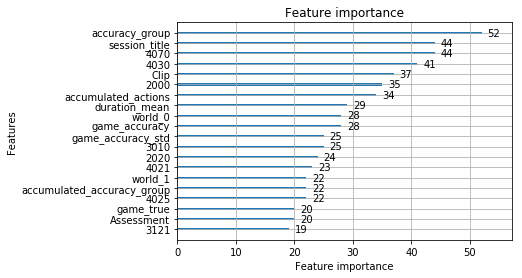

In [17]:
lgb.plot_importance(bst, max_num_features = 20)

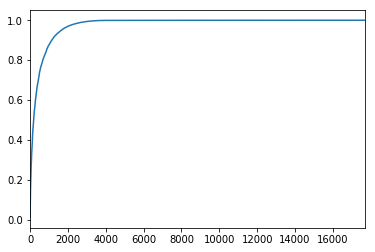

In [18]:
# Get training rows that are most similar to test
df_av = df[['installation_id', 'target']].copy()
df_av['preds'] = eval_preds
df_av_train = df_av[df_av.target == 1]
df_av_train = df_av_train.sort_values(by=['preds']).reset_index(drop=True)

# Check distribution
df_av_train.preds.plot()

# Store to feather
#df_av_train[['ID', 'preds']].reset_index(drop=True).to_feather('adversarial_validation.ft')

In [19]:
df_av_train.head(20) #because 0 is assigned to test data, pred close to 0 means that the data is similar to test data

,installation_id,target,preds
0,659fdff8,1,0.008187
1,d047c626,1,0.010275
2,d8912d1d,1,0.017301
3,664b49db,1,0.022852
4,a7d1a518,1,0.026779
5,f287c493,1,0.043544
6,0d230220,1,0.046088
7,139d4500,1,0.050279
8,1dfb04ab,1,0.057854
9,efeb3594,1,0.062678
